In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/APTOS')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas.util.testing as tm
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
train = pd.read_csv('train_split.csv')
val = pd.read_csv('val_split.csv')

# Image Preprocessing

Reference: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

In [ ]:
class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):

        ''' Initialzation of variables'''

        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the GRAY images'''

        mask = img>self.tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    def cropping_3D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the RGB images'''

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>self.tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark we return the image
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]  #for channel_1 (R)
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]  #for channel_2 (G)
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]  #for channel_3 (B)
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur = False):

        '''This function is used for adding Gaussian blur (image smoothing technique) which helps in reducing noise in the image.'''

        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),self.sigmaX),-4,128)
        return img

    def draw_circle(self,img, is_drawcircle = True):

        '''This function is used for drawing a circle from the center of the image.'''

        x = int(self.img_width/2)
        y = int(self.img_height/2)
        r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
        circle_img = np.zeros((img_height, img_width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping = True, is_gaussianblur = True):

        """
        This function takes an image -> crops the extra dark part, resizes, draw a circle on it, and finally adds a gaussian blur to the images
        Args : image - (numpy.ndarray) an image which we need to process
           cropping - (boolean) whether to perform cropping of extra part(True by Default) or not(False)
           gaussian_blur - (boolean) whether to apply gaussian blur to an image(True by Default) or not(False)
        Output : (numpy.ndarray) preprocessed image
        """

        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)  #calling cropping_2D for a GRAY image
        else:
            img = self.cropping_3D(img, is_cropping)  #calling cropping_3D for a RGB image
        img = cv2.resize(img, (self.img_height, self.img_width))  # resizing the image with specified values
        img = self.draw_circle(img)  #calling draw_circle
        img = self.Gaussian_blur(img, is_gaussianblur) #calling Gaussian_blur
        return img

In [ ]:
np.unique([1,1,2,3,1])

array([1, 2, 3])

In [ ]:
def images_per_class(class_labels, num, data, is_preprocess=False):
  labels = np.unique(class_labels)
  classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']

  for label in labels:
    plt.figure()

In [ ]:
def images_per_class(class_labels,num, data_x , is_preprocess = False):

    """
    This function plots "num" number of images per each class
    Args : class_labels - (Series Object) which contains the class_labels of train or validation sets.
           num - (Integer) sample number of images to be plot per each class
           data_x - (Series Object) which contains the id_code of each point in train or validation sets.
           is_preprocess - (boolean) whether to perform image processing(True) on image or not(False by Default)
    Output : None - this function doesn't return anything.
    """

    # class_labels num data_x data_y
    labels = list(set(class_labels))
    classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']
    iter=0
    for i in labels:
        j=1
        plt.figure(figsize=(20,5))
        for row in range(len(data_x)):
            if class_labels.iloc[row] == i:
                if is_preprocess == False:plt.subplot(1,num,j)
                else: plt.subplot(1,num*2,j)
                img = cv2.imread('train_images/'+data_x.iloc[row]+'.png')
                #plt.imshow(img)
                img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                plt.imshow(img1)
                plt.axis('off')
                plt.title("Class = {} ({})".format(class_labels.iloc[row],classes[iter]))
                j+=1
                if is_preprocess == True:
                    obj = ImageProcessing(img_width,img_height,no_channels,sigmaX=14)
                    image = obj.image_preprocessing(img)
                    plt.subplot(1,num*2,j)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title('==> After Image Processing')
                    j+=1
            if is_preprocess == False and j>num: break
            elif is_preprocess == True and j>num*2: break
        iter+=1
        plt.show()

In [ ]:
images_per_class(train['diagnosis'],5,train['id_code'],False)  #printing 5 random images per each class.

Output hidden; open in https://colab.research.google.com to view.

# Exploring the dataset

Each row depicts the severity level of the disease retinopathy.<br>
There are four major problems in our dataset which will make our model difficult to spot the identities.

**Images with dark color Illumination:**<br>
Some of the images are very dark which will mislead our model towards incorrect classification.
<img src='https://imgur.com/7RDWSpZ.png'>

**Images with different color invertion:**<br>
Here some images are different in color shades from the rest of the images like blue, pink, green.
<img src='https://imgur.com/GRdbTY5.png'>

**Images with uninformative extra dark black pixels**<br>
This is the major issue because while resizing the image most of the informative will become small.
<img src='https://imgur.com/9t0PSn0.png'>

**Images with irregular cropping**<br>
Their are four different types of cropping in the dataset<br>
i) Square crop: square image with No cropping needed

ii) vertical crop: rectangular image with lossy vertical cropping.

iii) tight crop: images with tight cropping.(lossy vertical and horizontal cropping)

iv) space crop: images with more uninformative pixels.
<img src='https://imgur.com/5XrnmHz.png'>
        
Most of the test images are type-iii while train images are type-iii and type-i

In [ ]:
def plotting(img, title,i):
    """
    This function is used for subplots
    Args: img (numpy.ndarray) - image we need to plot
          title(string) - title of the plot
          i (integer) -  column number
    output: None - this function doesn't return anything.
    """
    plt.subplot(1,5,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

In [ ]:

# Intialization of variables which are useful for the later tasks.
img_width = 512
img_height = 512
no_channels = 3
split_size = 0.15
class_labels = {0: 'No DR[0]',1: 'Mild[1]', 2: 'Moderate[2]', 3: 'Severe[3]', 4: 'Proliferative DR[4]'}

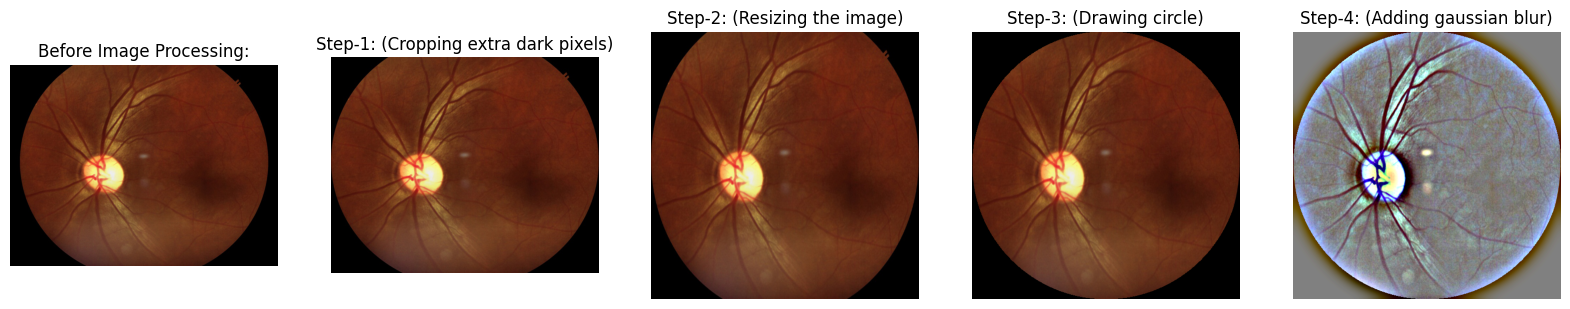

In [ ]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 14)
img = 'train_images/201f882365d3.png'  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,5))
plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Step-3: (Drawing circle)',4)
img = obj1.image_preprocessing(img,'True')
plotting(img,'Step-4: (Adding gaussian blur)',5)

### Plotting sample images of each class before and after Image Preprocessing:

In [ ]:
images_per_class(train['diagnosis'],3,train['id_code'],True)

Output hidden; open in https://colab.research.google.com to view.

I tried using multiple values of sigmaX and the value = 14 works best for this case.

### Converting Images to Vectors and storing it into files:

Image preprocessing is a time taking process. Hence I am storing preprocessed images into a vector to save time on preprocessing images, every time running the program.

## Image Convertion:

In [ ]:
import time
def image_2_vector(data, sep):
    """
    This function is used for Converting an images into a vector and storing it in a file (.npy) format.
    Input: data (Series Object) - which contains the path of the images
           sep (String)   - used in file creation
    Output: None - This function doesn't return anything.
    """
    start_time = time.time()  # storing timestamp
    image_vector = np.empty((len(data),img_width, img_height, no_channels), dtype = np.uint8)
    image_processing = ImageProcessing(img_width, img_height, no_channels, sigmaX)  # Object creation
    if sep !='test':
        c = 'train_images/'
    else:
        c = 'test_images/'
    for iter,row in enumerate(tqdm(data)):
        img_path = c+data.iloc[iter]+'.png'
        img = cv2.imread(img_path)
        img = image_processing.image_preprocessing(img)    #calling image_preprocessing
        image_vector[iter,:,:,:] = img

    if sep == 'training': print("\nShape of the vector:",image_vector.shape)
    else: print("\n\nShape of the vector:",image_vector.shape)
    print("Time taken to process the {} images: {} seconds".format(sep,np.round(time.time()-start_time,5)))
    path = 'Processed_images'
    print("... Saving image_vector to {}".format(path+'/'+sep))

    if sep == 'training':
        print("\n","-"*100,"\n")
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path+'/'+sep+'.npy', image_vector)  #saving file

In [ ]:
sigmaX = 14
image_2_vector(train['id_code'], "training") # function calling
image_2_vector(val['id_code'],"validation")  #function calling

100%|██████████| 3112/3112 [1:01:37<00:00,  1.19s/it]



Shape of the vector: (3112, 512, 512, 3)
Time taken to process the training images: 3697.88761 seconds
... Saving image_vector to Processed_images/training

 ---------------------------------------------------------------------------------------------------- 



100%|██████████| 550/550 [11:00<00:00,  1.20s/it]




Shape of the vector: (550, 512, 512, 3)
Time taken to process the validation images: 660.11258 seconds
... Saving image_vector to Processed_images/validation


In [ ]:
test = pd.read_csv("test.csv")
image_2_vector(test['id_code'], 'test')   #function calling

100%|██████████| 1928/1928 [23:57<00:00,  1.34it/s]




Shape of the vector: (1928, 512, 512, 3)
Time taken to process the test images: 1437.75372 seconds
... Saving image_vector to Processed_images/test


In [ ]:
np.save('Processed_images/train_labels.npy', train['diagnosis'].values)
np.save('Processed_images/val_labels.npy', val['diagnosis'].values)